In [ ]:
!pip install matplotlib numpy ipympl ipywidgets==7.7.2
%matplotlib widget

from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Optional, Callable
import matplotlib.figure
import matplotlib.axes

In [ ]:
import logging
from pathlib import Path
from typing import Any, Dict, List, Optional, Sequence

import numpy as np
import pandas as pd  # type: ignore

from mrl.util import dump, load


class Results:
    current_experiment: Optional[str]

    def __init__(self, outdir: Path, load_contents: bool = False):
        self.outdir = outdir
        self.outdir.mkdir(parents=True, exist_ok=True)

        self.experiments: Dict[str, Dict[str, Any]] = {}

        if load_contents:
            for experiment_dir in self.outdir.iterdir():
                if experiment_dir.is_dir():
                    experiment_name = experiment_dir.parts[-1]
                    self.start(experiment_name)
                    for file in experiment_dir.iterdir():
                        if file.suffix not in [".pkl", ".npy"]:
                            continue
                        obj_name = file.stem
                        self.experiments[experiment_name][obj_name] = load(file)

    def start(self, experiment_name: str):
        self.experiments[experiment_name] = self.experiments.get(experiment_name, {})
        self.current_experiment = experiment_name
        (self.outdir / self.current_experiment).mkdir(exist_ok=True)

    def update(self, name: str, value: Any, save: bool = True) -> None:
        assert self.current_experiment is not None, "No current experiment"
        self.experiments[self.current_experiment][name] = value
        if save:
            dump(value, self.outdir / self.current_experiment / name)

    def update_dict(self, name: str, key: Any, value: Any, save: bool=True) -> None:
        assert self.current_experiment is not None, "No current experiment"
        d = self.experiments[self.current_experiment].get(name, {})
        d[key] = value
        self.experiments[self.current_experiment][name] = d
        if save:
            dump(value, self.outdir / self.current_experiment / name )

    def has(self, name: str) -> bool:
        return any(name in exp.keys() for exp in self.experiments.values())

    def get(self, name: str) -> Any:
        assert self.current_experiment is not None, "No current experiment"
        return self.experiments[self.current_experiment].get(name)

    def getall(self, name: str) -> pd.DataFrame:
        if not self.has(name):
            raise ValueError(f"No {name} values in any experiment")

        out = pd.DataFrame(columns=["trial", "time", name])
        for exp_name, exp in self.experiments.items():
            if name not in exp.keys():
                logging.warning(
                    f"{name} not present in experiment {exp_name}, skipping"
                )
                continue

            value = exp[name]
            if isinstance(value, np.ndarray):
                if len(value.shape) > 1:
                    raise NotImplementedError(
                        f"Underlying array with {len(value.shape)} dims > 1 not supported"
                    )
                df = self.__make_df(name, value)
                df["trial"] = exp_name
                out = out.append(df.copy())
            elif isinstance(value, dict):
                for modality, v in value.items():
                    df = self.__make_df([name], v)
                    df["trial"] = exp_name
                    df["modality"] = modality
                    out = out.append(df.copy())

        out = out.reset_index(drop=True)
        return out

    def experiment_names(self) -> List[str]:
        return list(self.experiments.keys())

    @staticmethod
    def __make_df(columns: Sequence[str], value: np.ndarray) -> pd.DataFrame:
        assert value.ndim == 1, "Only 1D arrays supported"
        df = pd.DataFrame(value, columns=columns)
        df.index.name = "time"
        df = df.reset_index()
        return df

    def close(self):
        self.current_experiment = None


In [36]:
def plot_dict(
    data: Dict[str, np.ndarray],
    title: str,
    xlabel: str,
    ylabel: str,
    customization: Optional[
        Callable[[matplotlib.figure.Figure, matplotlib.axes.Axes], None]
    ] = None,
) -> None:
    fig = plt.figure(figsize=(15, 5))
    axes = fig.subplots()
    axes.set_prop_cycle(color=plt.cm.tab20.colors)
    lines = []
    for name, d in data.items():
        lines.append(axes.plot(d, label=name, picker=10)[0])
    axes.set_title(title)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    legend = axes.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    if customization is not None:
        customization(fig, axes)

    legend_to_line = {k: v for k, v in zip(legend.get_lines(), lines)}
    line_to_legend = {v: k for k, v in legend_to_line.items()}    
    for legend_entry in legend.get_lines():
        legend_entry.set_picker(10)
    for legend_handle in legend.legendHandles:
    
        legend_handle.set_picker(10)
        legend_handle.set_linewidth(10.0)

    def on_pick(event):
        artist = event.artist
        if artist in lines:
            origline = artist
            legline = line_to_legend[origline]
        elif artist in legend.get_lines():
            legline = artist
            origline = legend_to_line[legline]

        visible = not origline.get_visible()
        origline.set_visible(visible)

        legline.set_alpha(1.0 if visible else 0.2)
        fig.canvas.draw()

    fig.canvas.mpl_connect("pick_event", on_pick)
    fig.show()

def plot_rewards(
    rewards: Dict[str, np.ndarray],
) -> None:
    ndims = list(rewards.values())[0].shape[1]
    for dim in range(ndims):
        nth_dim = {name: r[:, dim] for name, r in rewards.items()}
        plot_dict(
            data=nth_dim,
            title=f"{dim}-th dimension of reward",
            xlabel="Preferences",
            ylabel=f"{dim}-th dimension of reward",
            customization=lambda fig, ax: ax.set_ylim((-1, 1)),
        )

def plot_entropies(entropies: Dict[str, np.ndarray]) -> None:
    plot_dict(
        data=entropies,
        title="Posterior entropy",
        xlabel="Human preferences",
        ylabel="Entropy",
    )

def plot_counts(
    counts: Dict[str, np.ndarray], threshold: int = 200
) -> None:
    max_count = max(np.max(c) for c in counts.values())
    if isinstance(counts, dict):
        plot_dict(
            data=counts,
            title="Number of rewards with nonzero likelihood",
            xlabel="Number of preferences",
            ylabel="Count",
            customization=lambda fig, ax: ax.set_ylim((0, max_count * 1.05)),
        )

    if any(np.any(c < threshold) for c in counts.values()):
        small_counts = {
            name: c[c < threshold]
            for name, c in counts.items()
            if np.any(c < threshold)
        }
        if isinstance(counts, dict):
            plot_dict(
                data=small_counts,
                title="Number of rewards with nonzero likelihood (small)",
                xlabel="Number of preferences",
                ylabel="Count",
                customization=lambda fig, ax: ax.set_ylim((0, max_count * 1.05)),
            )   
def plot_dispersions(
    dispersions: Dict[str, np.ndarray]
) -> None:
    plot_dict(
        data=dispersions,
        title="Concentration of posterior with data",
        xlabel="Human preferences",
        ylabel="Mean dispersion",
    )

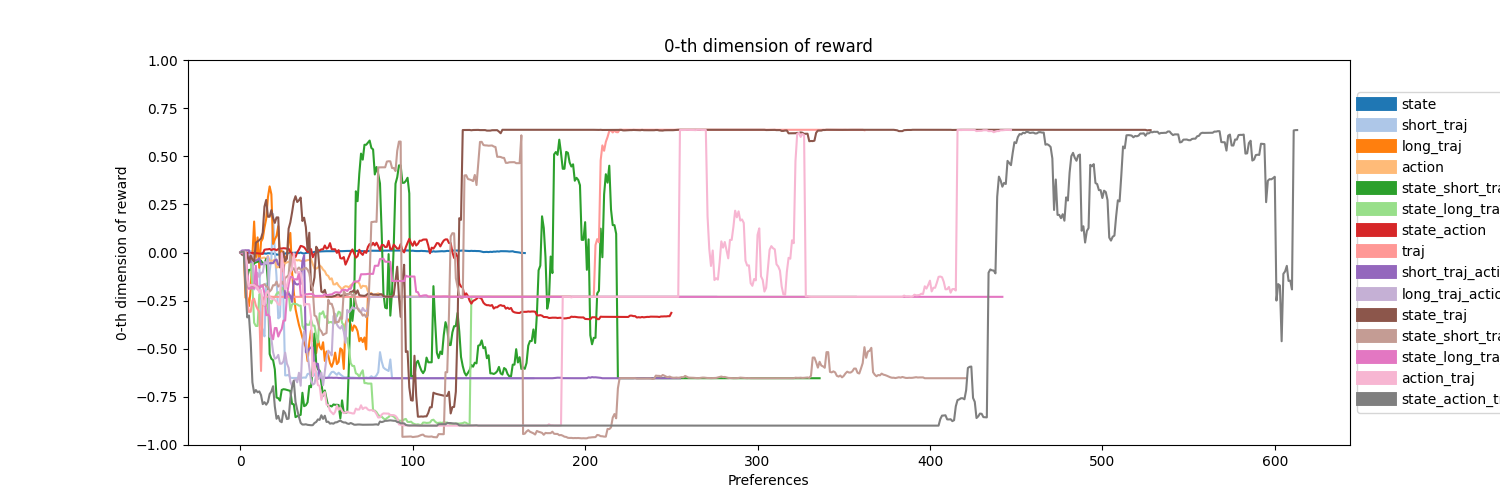

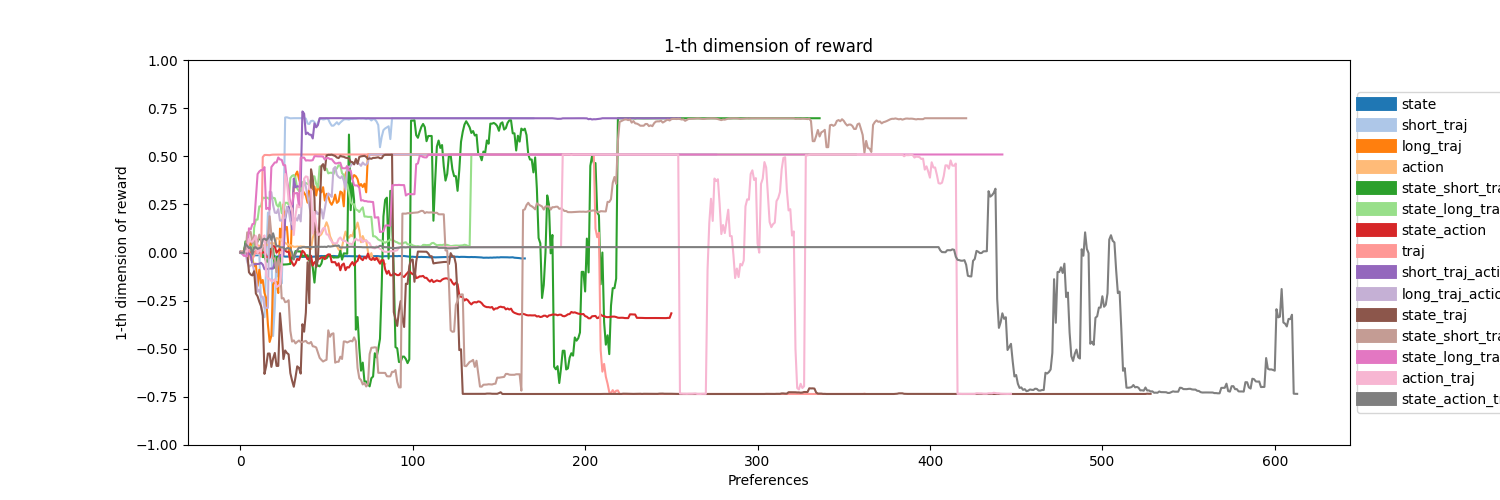

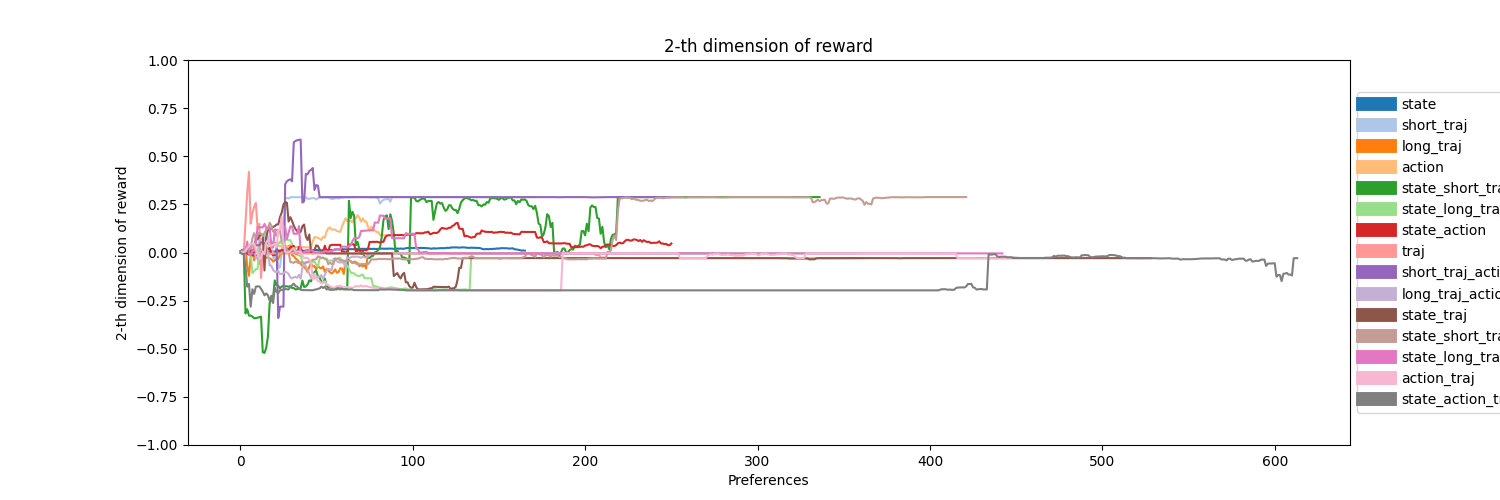

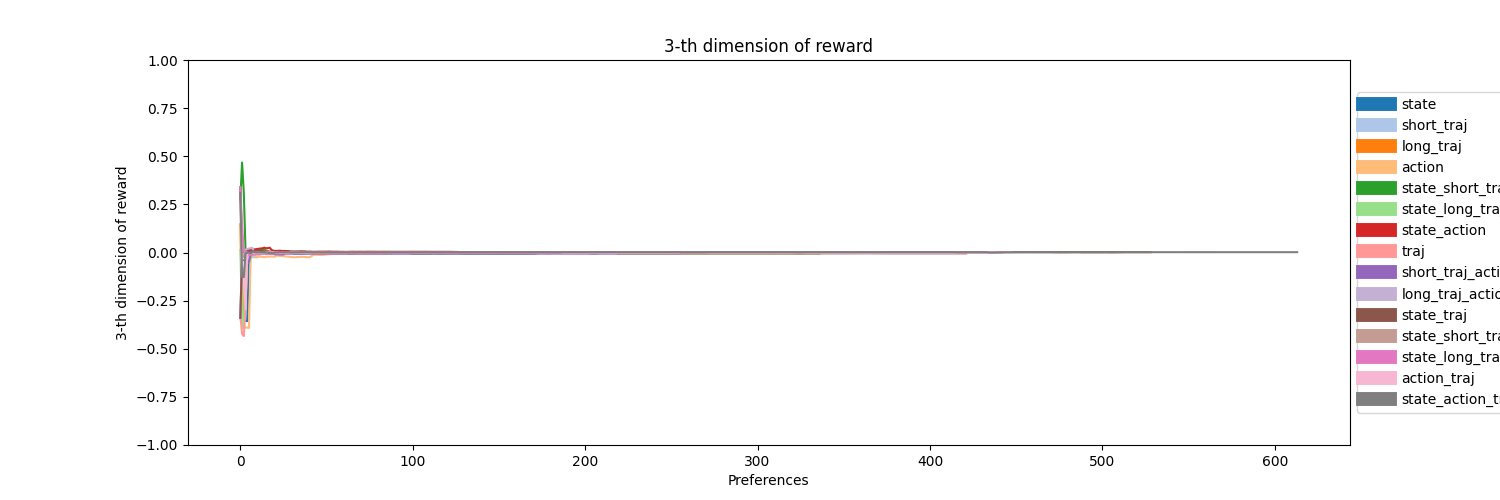

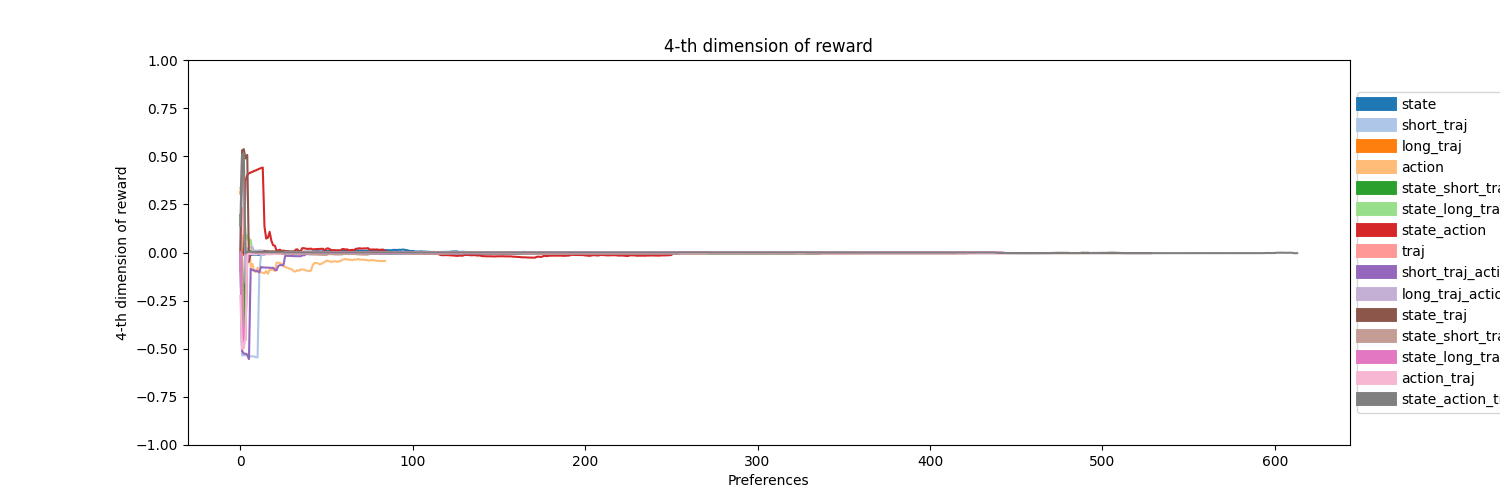

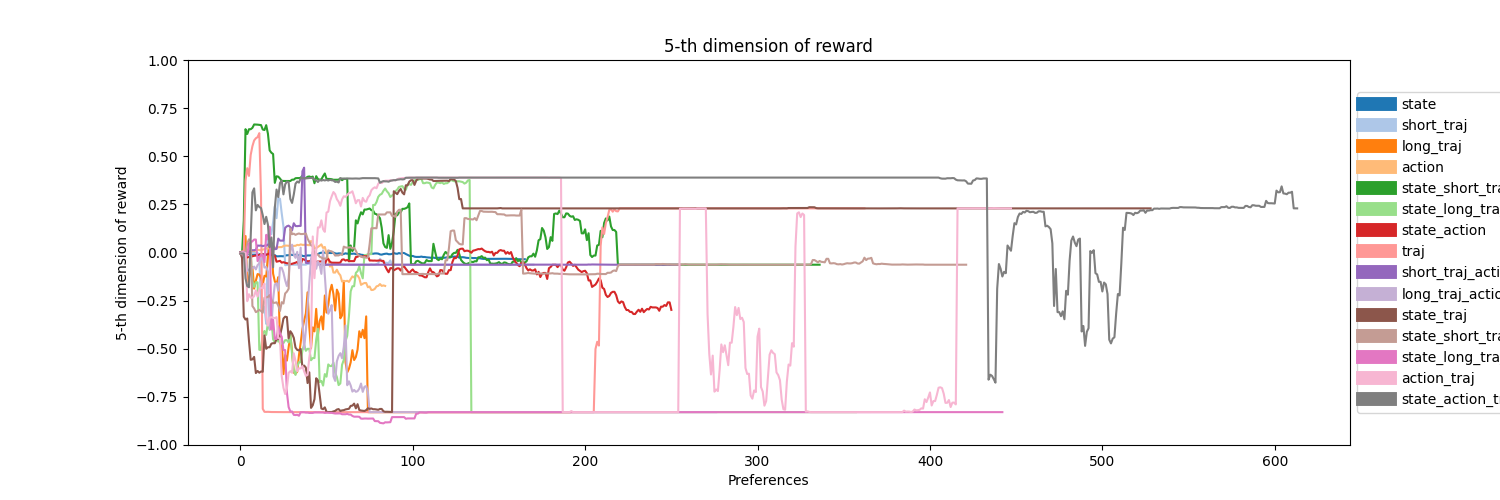

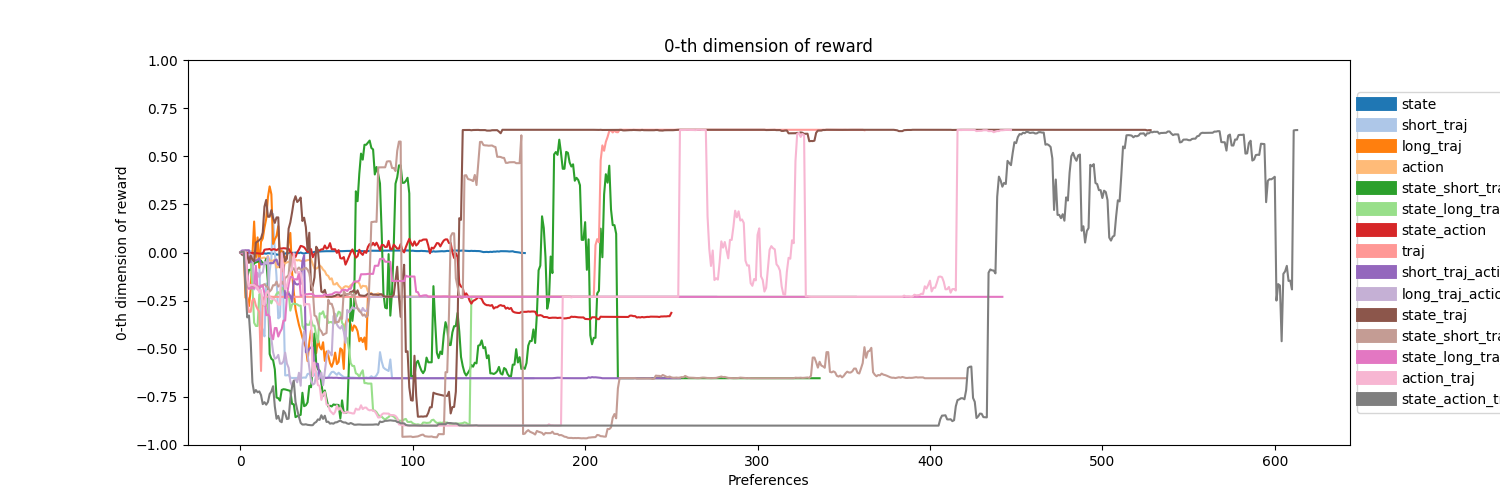

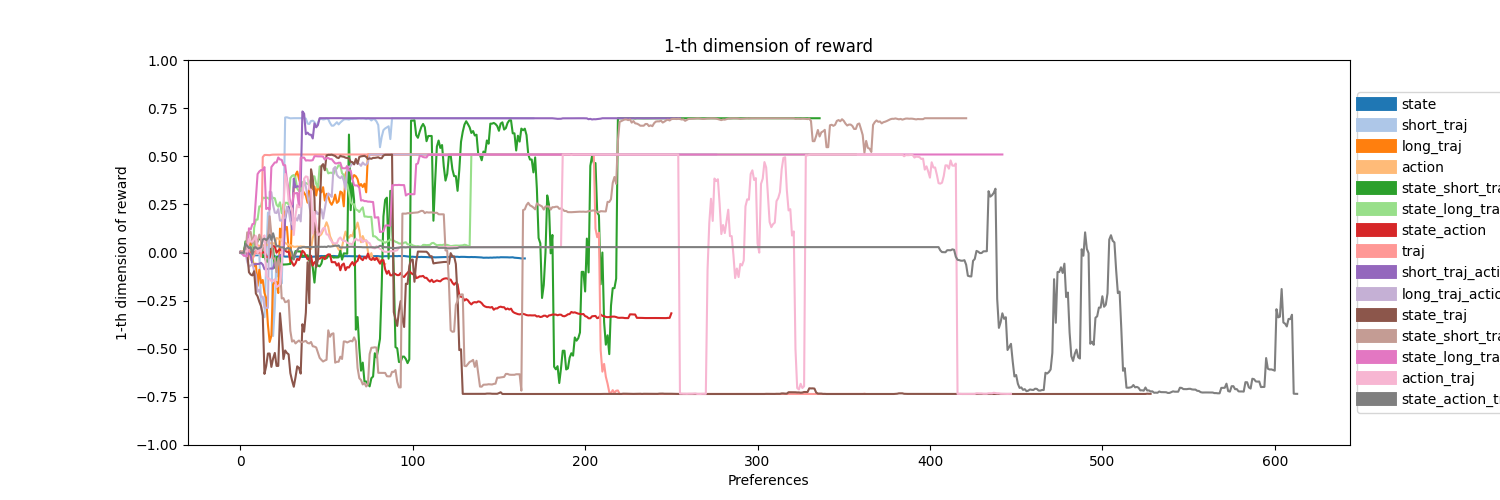

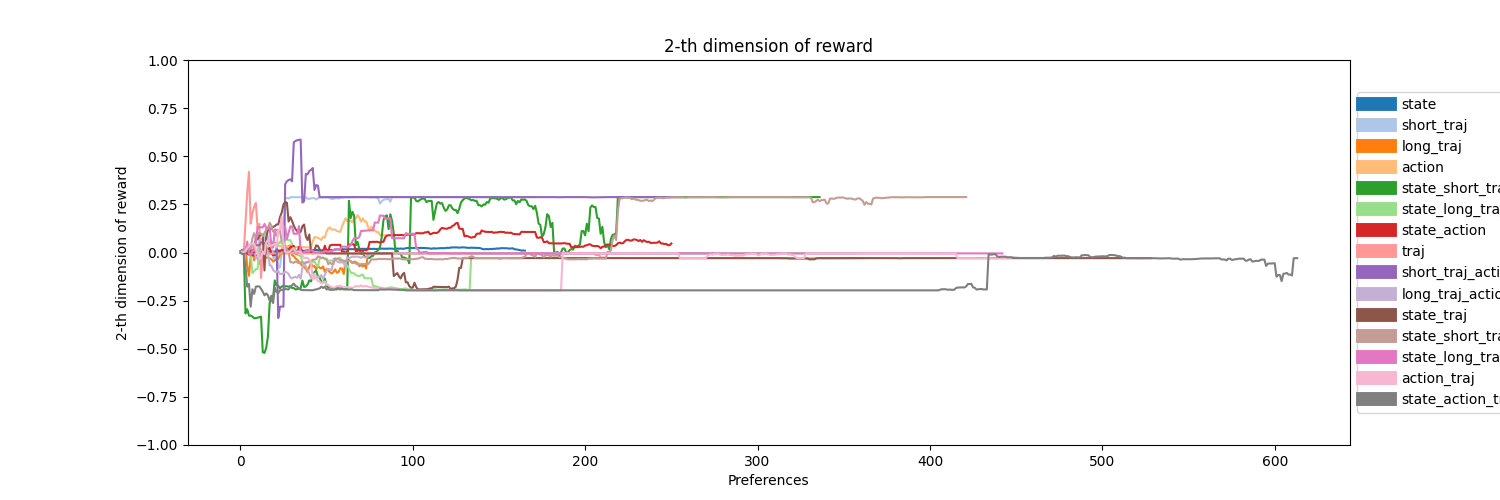

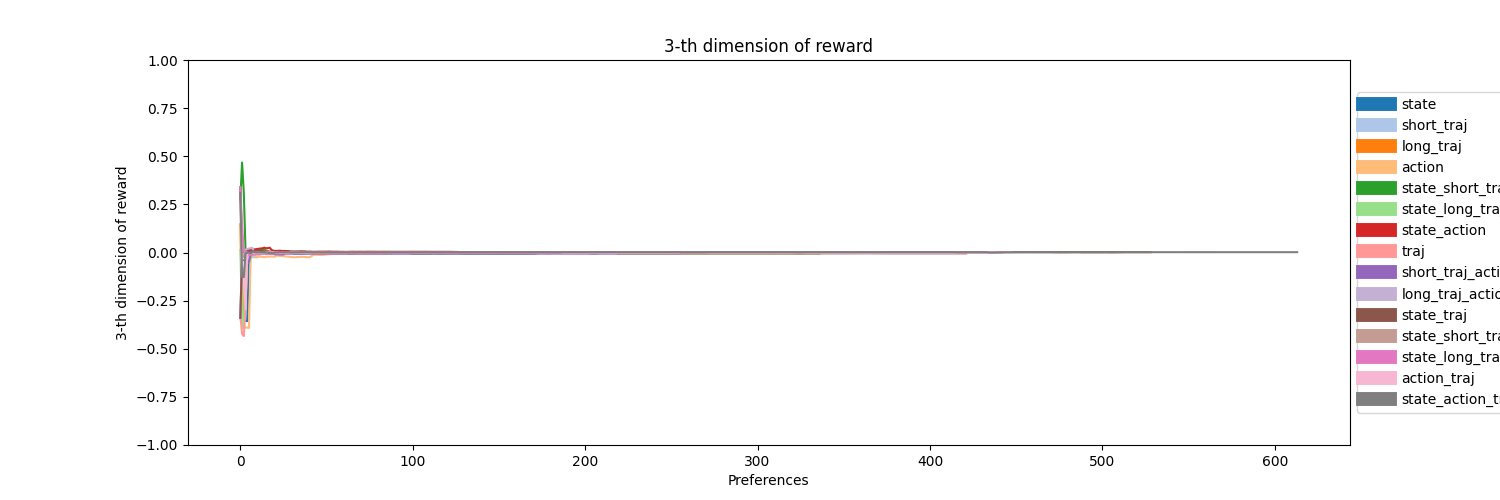

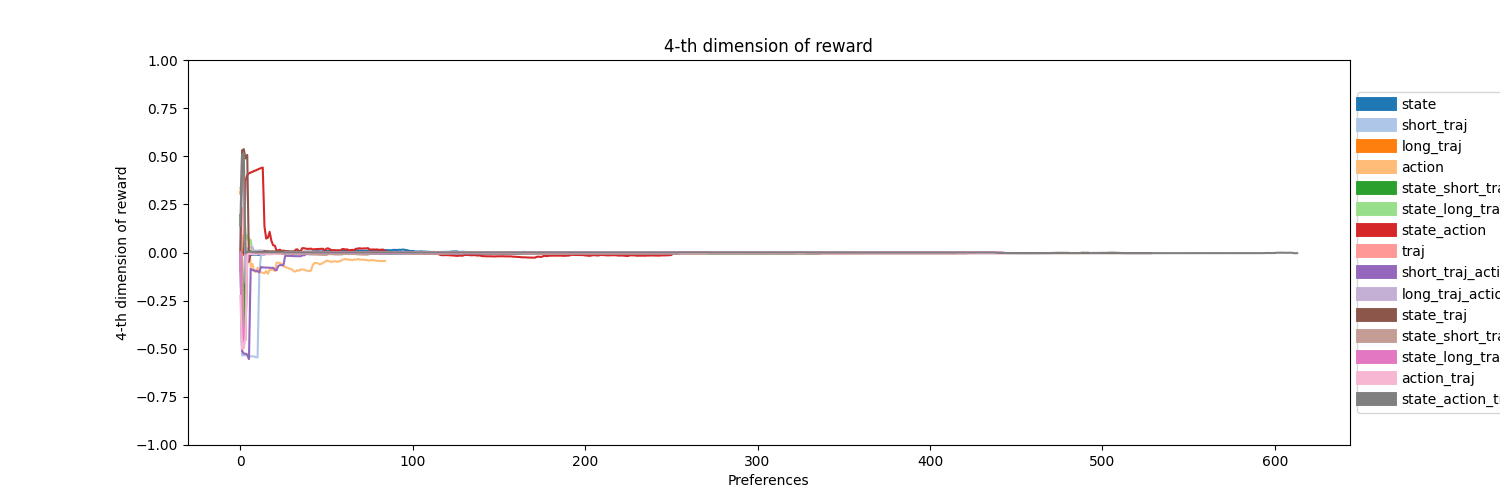

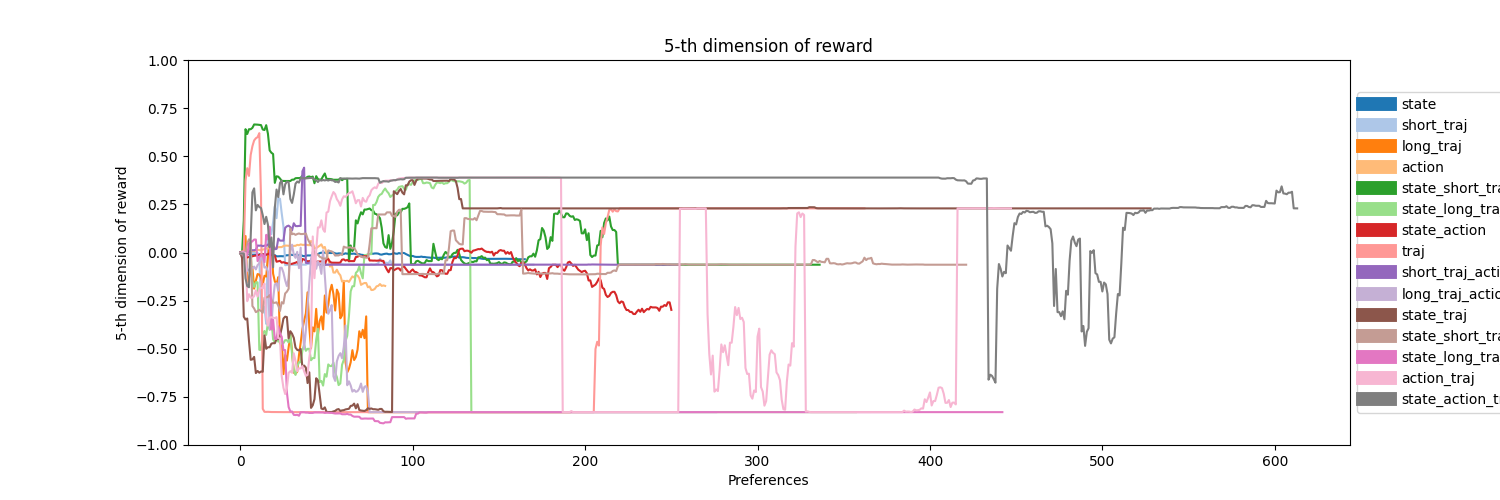

Line2D(state)
Line2D(short_traj)
Line2D(state)
Line2D(long_traj)
Line2D(state)
Line2D(action)
Line2D(state_short_traj)
Line2D(state_long_traj)
Line2D(state_action)
Line2D(traj)
Line2D(short_traj_action)
Line2D(long_traj_action)
Line2D(state_traj)
Line2D(state_short_traj_action)
Line2D(state_long_traj_action)
Line2D(action_traj)
Line2D(state_action_traj)
Line2D(action_traj)
Line2D(state_long_traj_action)
Line2D(state_long_traj_action)
Line2D(state_short_traj_action)
Line2D(state_short_traj_action)
Line2D(state_traj)
Line2D(long_traj_action)
Line2D(long_traj_action)
Line2D(long_traj_action)
Line2D(long_traj_action)
Line2D(short_traj_action)
Line2D(short_traj_action)
Line2D(traj)
Line2D(traj)
Line2D(traj)
Line2D(state_action)
Line2D(state_action)
Line2D(state_long_traj)
Line2D(state_long_traj)
Line2D(state_short_traj)
Line2D(long_traj)
Line2D(long_traj)
Line2D(long_traj)
Line2D(long_traj)
Line2D(state_short_traj)
Line2D(traj)
Line2D(state_traj)
Line2D(action_traj)
Line2D(state_action_traj

In [38]:
results = Results(Path("/nfs/data/joschnei/multimodal-reward-learning/data/miner/inference/2022-11-10:16:45:03/trials"), load_contents=True)
results.start("human")
# if counts := results.get("count"):
#     plot_counts(counts)
if mean_rewards := results.get("mean_reward"):
    plot_rewards(mean_rewards)
# if entropies := results.get("entropy"):
#     plot_entropies(entropies)
# if dispersion_mean := results.get("dispersion_mean"):
#     plot_dispersions(dispersion_mean)

In [58]:
mean_rewards = results.get("mean_reward")
dims = list(mean_rewards.values())[0].shape[1]
order = [1,-1,-1,-1,-1,1]
regret = {}
for dim in range(dims):
    print(f"\nDimension {dim}")
    last_nth_dim = [(name, r[-1, dim]) for name, r in mean_rewards.items()]
    last_nth_dim.sort(key=lambda x: order[dim]*x[1], reverse=True)
    for name, r in last_nth_dim:
        print(f"{name}: {r}")
    for name, r in last_nth_dim:
        regret[name] = regret.get(name, 0) + np.abs(r - last_nth_dim[0][1])
print("\nRegret")
for name, regret in sorted(regret.items(), key=lambda x: x[1]):
    print(f"{name}: {regret}")


Dimension 0
state_action_traj: 0.6360874910220037
action_traj: 0.6358919566657832
state_traj: 0.6356054158426481
traj: 0.6353430205175205
state: -0.002892264427034724
long_traj: -0.23034777697419068
state_long_traj: -0.23034777697419068
long_traj_action: -0.23034777697419068
state_long_traj_action: -0.23034777697419068
action: -0.23204461488639722
state_action: -0.3136703914799993
state_short_traj_action: -0.6531100328956063
state_short_traj: -0.653143300185611
short_traj_action: -0.6531577753753046
short_traj: -0.6531577754832215

Dimension 1
state_action_traj: -0.7343287192302685
action_traj: -0.7342316501704997
state_traj: -0.734089402798852
traj: -0.7339591419690993
state_action: -0.3159482971219468
action: -0.05956141008141487
state: -0.030873592858759846
long_traj: 0.5091668280925686
state_long_traj: 0.5091668280925686
long_traj_action: 0.5091668280925686
state_long_traj_action: 0.5091668280925686
state_short_traj_action: 0.6974090754486022
state_short_traj: 0.6974459986537351
s